### 深度学习

深度学习是机器学习的一个类型，通常被定义为一种“表征学习”（Representation Learning）的方法。这个方法及其对应的模型，是直接从图像、文本或声音等非结构化数据（Unstructured Data）中学习执行分类任务。这类模型通常使用神经网络（Nerual Networks）架构为基础。之所以称为“深度”，是指神经网络中的层数，层数越多、网络越深。传统的神经网络只包含 2 层或 3 层，而深度网络可能多达几百层。

和前面文章中我们通过数理统计方法的建模，比如回归分析（Regression analysis）相比，深度学习建模通过多层处理，逐渐将初始的“低层”特征表示转化为“高层”特征表示后，用“简单模型”即可完成复杂的分类等学习任务。当前用的比较多的两类建模的方法分别为：循环神经网络（Recurrent Neural Network, RNN）和长短期记忆网络（LSTM，Long Short-Term Memory）。

### 循环神经网络

在传统的神经网络模型中，是从输入层到隐含层再到输出层，层与层之间是全连接的，每层之间的节点是无连接的。但是这种普通的神经网络对于很多问题却无能无力。例如，你要预测句子的下一个单词是什么，一般需要用到前面的单词，因为一个句子中前后单词并不是独立的，它们是有上下文关系的。RNN之所以称为循环神经网路，即一个序列当前的输出与前面的输出也有关。具体的表现形式为，网络会对前面的信息进行记忆、并应用于当前输出的计算中，即隐藏层之间的节点不再无连接而是有连接的。隐藏层的输入不仅包括输入层的输出还包括上一时刻隐藏层的输出。这样的描述听起来对时间序列数据分析很有帮助，因为我们之前的分析已经看到，个股的现价𝑥𝑡和前序价格𝑥(𝑡−ℎ)有显著的相关性，那么用循环神经网路对时间序列建模感觉就是顺理成章的事情。起码，是一定值得试下的，我们继续演示下如何操作。

首先，还是先导入几个python模块。除了之前用到的统计模块外，深度学习最主要的模块是基于深度学习框架Tensorflow、以及Keras。

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, 
                                     Activation, Flatten, 
                                     MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

分别定义预测的次数=13，变量=1

In [2]:
n_steps=13
n_features=1

定义一个RNN的模型、以及神经元的数量等模型参数

In [3]:
model=Sequential()
model.add(SimpleRNN(512, activation='relu', 
                    input_shape=(n_steps, n_features),
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [4]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 13, 512)           263168    
                                                                 
 dropout (Dropout)           (None, 13, 512)           0         
                                                                 
 dense (Dense)               (None, 13, 256)           131328    
                                                                 
 flatten (Flatten)           (None, 3328)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3329      
                                                                 
Total params: 397,825
Trainable params: 397,825
Non-trainable params: 0
_________________________________________________________________


In [63]:
def split_sequence(sequence,n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

这次我们以沪深300指数（CSI 300 Index）为例，先下载最近一年的历史日线数据，220个交易日的收盘价。

In [65]:
import akshare as ak
ticker='sh000300'
csi300Daily=ak.stock_zh_index_daily(symbol=ticker)
split=csi300Daily.shape[0]-220
csi300Close=csi300Daily.close.iloc[split:]
csi300Date=csi300Daily.date.iloc[split:]

我们先看下收盘价对应的走势图，过去一年沪深300从5400点跌到了400点附近。

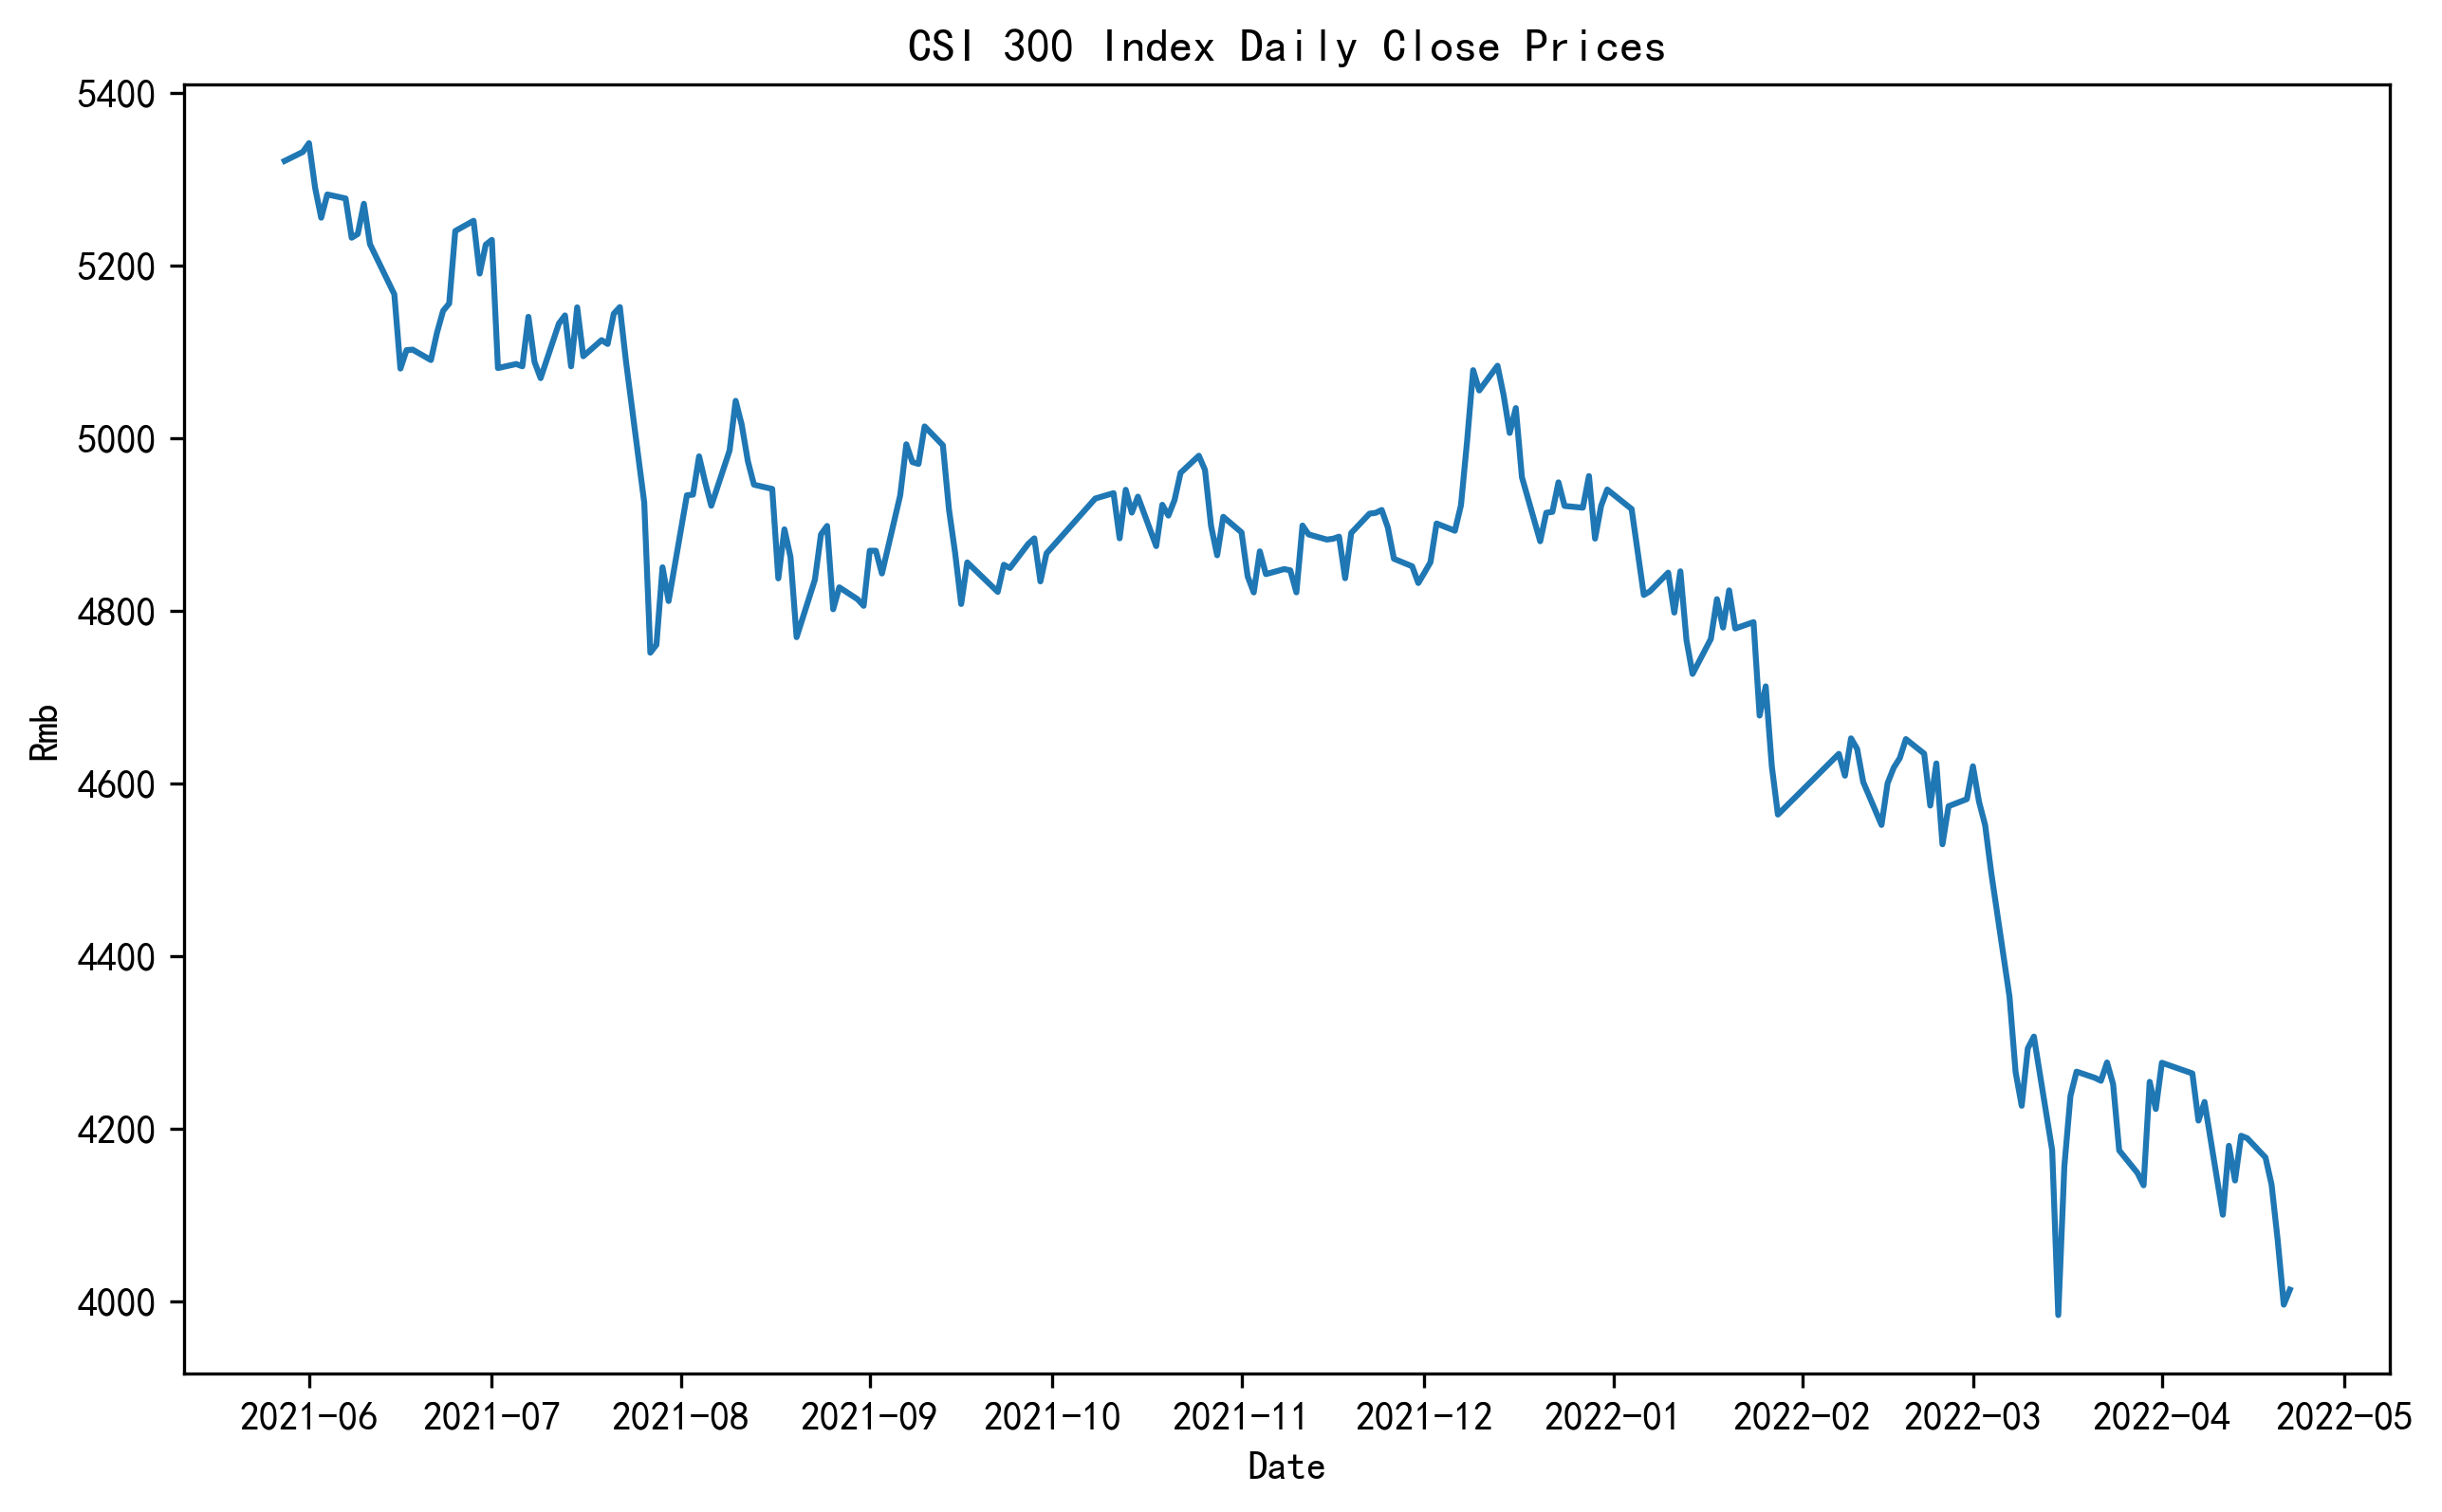

In [66]:
x=csi300Date
y=csi300Close
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.title('CSI 300 Index Daily Close Prices')
plt.ylabel('Rmb')
plt.xlabel('Date')
plt.show()

根据之前文章分析的结论，我们不能直接用收盘价建模，因为数据是非平衡的。我们仍然通过取收盘价的当前值和其前一个值的差，即：𝑥𝑡和𝑥𝑡−1的差可以平划数据里的非平稳性。并将数据按训练集、测试集切分。

In [67]:
csi300Diff=csi300Close.diff().dropna()
split=int(len(csi300Diff.values)*0.95)
csi300Diff_train=csi300Diff.iloc[:split]
csi300Diff_test=csi300Diff.iloc[split:]

由于之前定义的split_sequence函数中，索引（index）是从0开始计算，我们需要把训练集中数据的索引重置为从0开始，这里用了DataFrame里的reset_index()方法。接着，调用split_sequence函数，将训练集调整为RNN模型所需的输入格式。可以看到，训练集数据，x_csi300被转换为了三维结构。

In [69]:
csi300Diff_train=csi300Diff_train.reset_index(drop=True)
x_csi300,y_csi300=split_sequence(csi300Diff_train, n_steps)
x_csi300=x_csi300.reshape((x_csi300.shape[0],x_csi300.shape[1],n_features))
print(x_csi300.shape)
print(y_csi300.shape)

(195, 13, 1)
(195,)


In [71]:
history=model.fit(x_csi300, y_csi300, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split=0.10)

现在可以调用之前定义好的RNN模型。

In [72]:
start=x_csi300[x_csi300.shape[0] - n_steps]
x_input=start
x_input=x_input.reshape((1, n_steps, n_features))

In [82]:
tempList_csi300=[]
for i in range(len(csi300Diff_test)):
    x_input=x_input.reshape((1, n_steps, n_features))
    yhat=model.predict(x_input, verbose=0)
    x_input=np.append(x_input, yhat)
    x_input=x_input[1:]
    tempList_csi300.append(yhat)

接着，我们就可以调用训练好的模型做预测，下面是预测值和实际值的比较。虽然，我们训练集和测试集的数据量不够多，但肉眼可见的预测效果比之前用自回归模型（AR）、差分整合移动平均自回归模型（ARIMA）还是有明显提升的。

当然，我们也看到深度模型的预测效果也仍存在很大调优和提升空间。

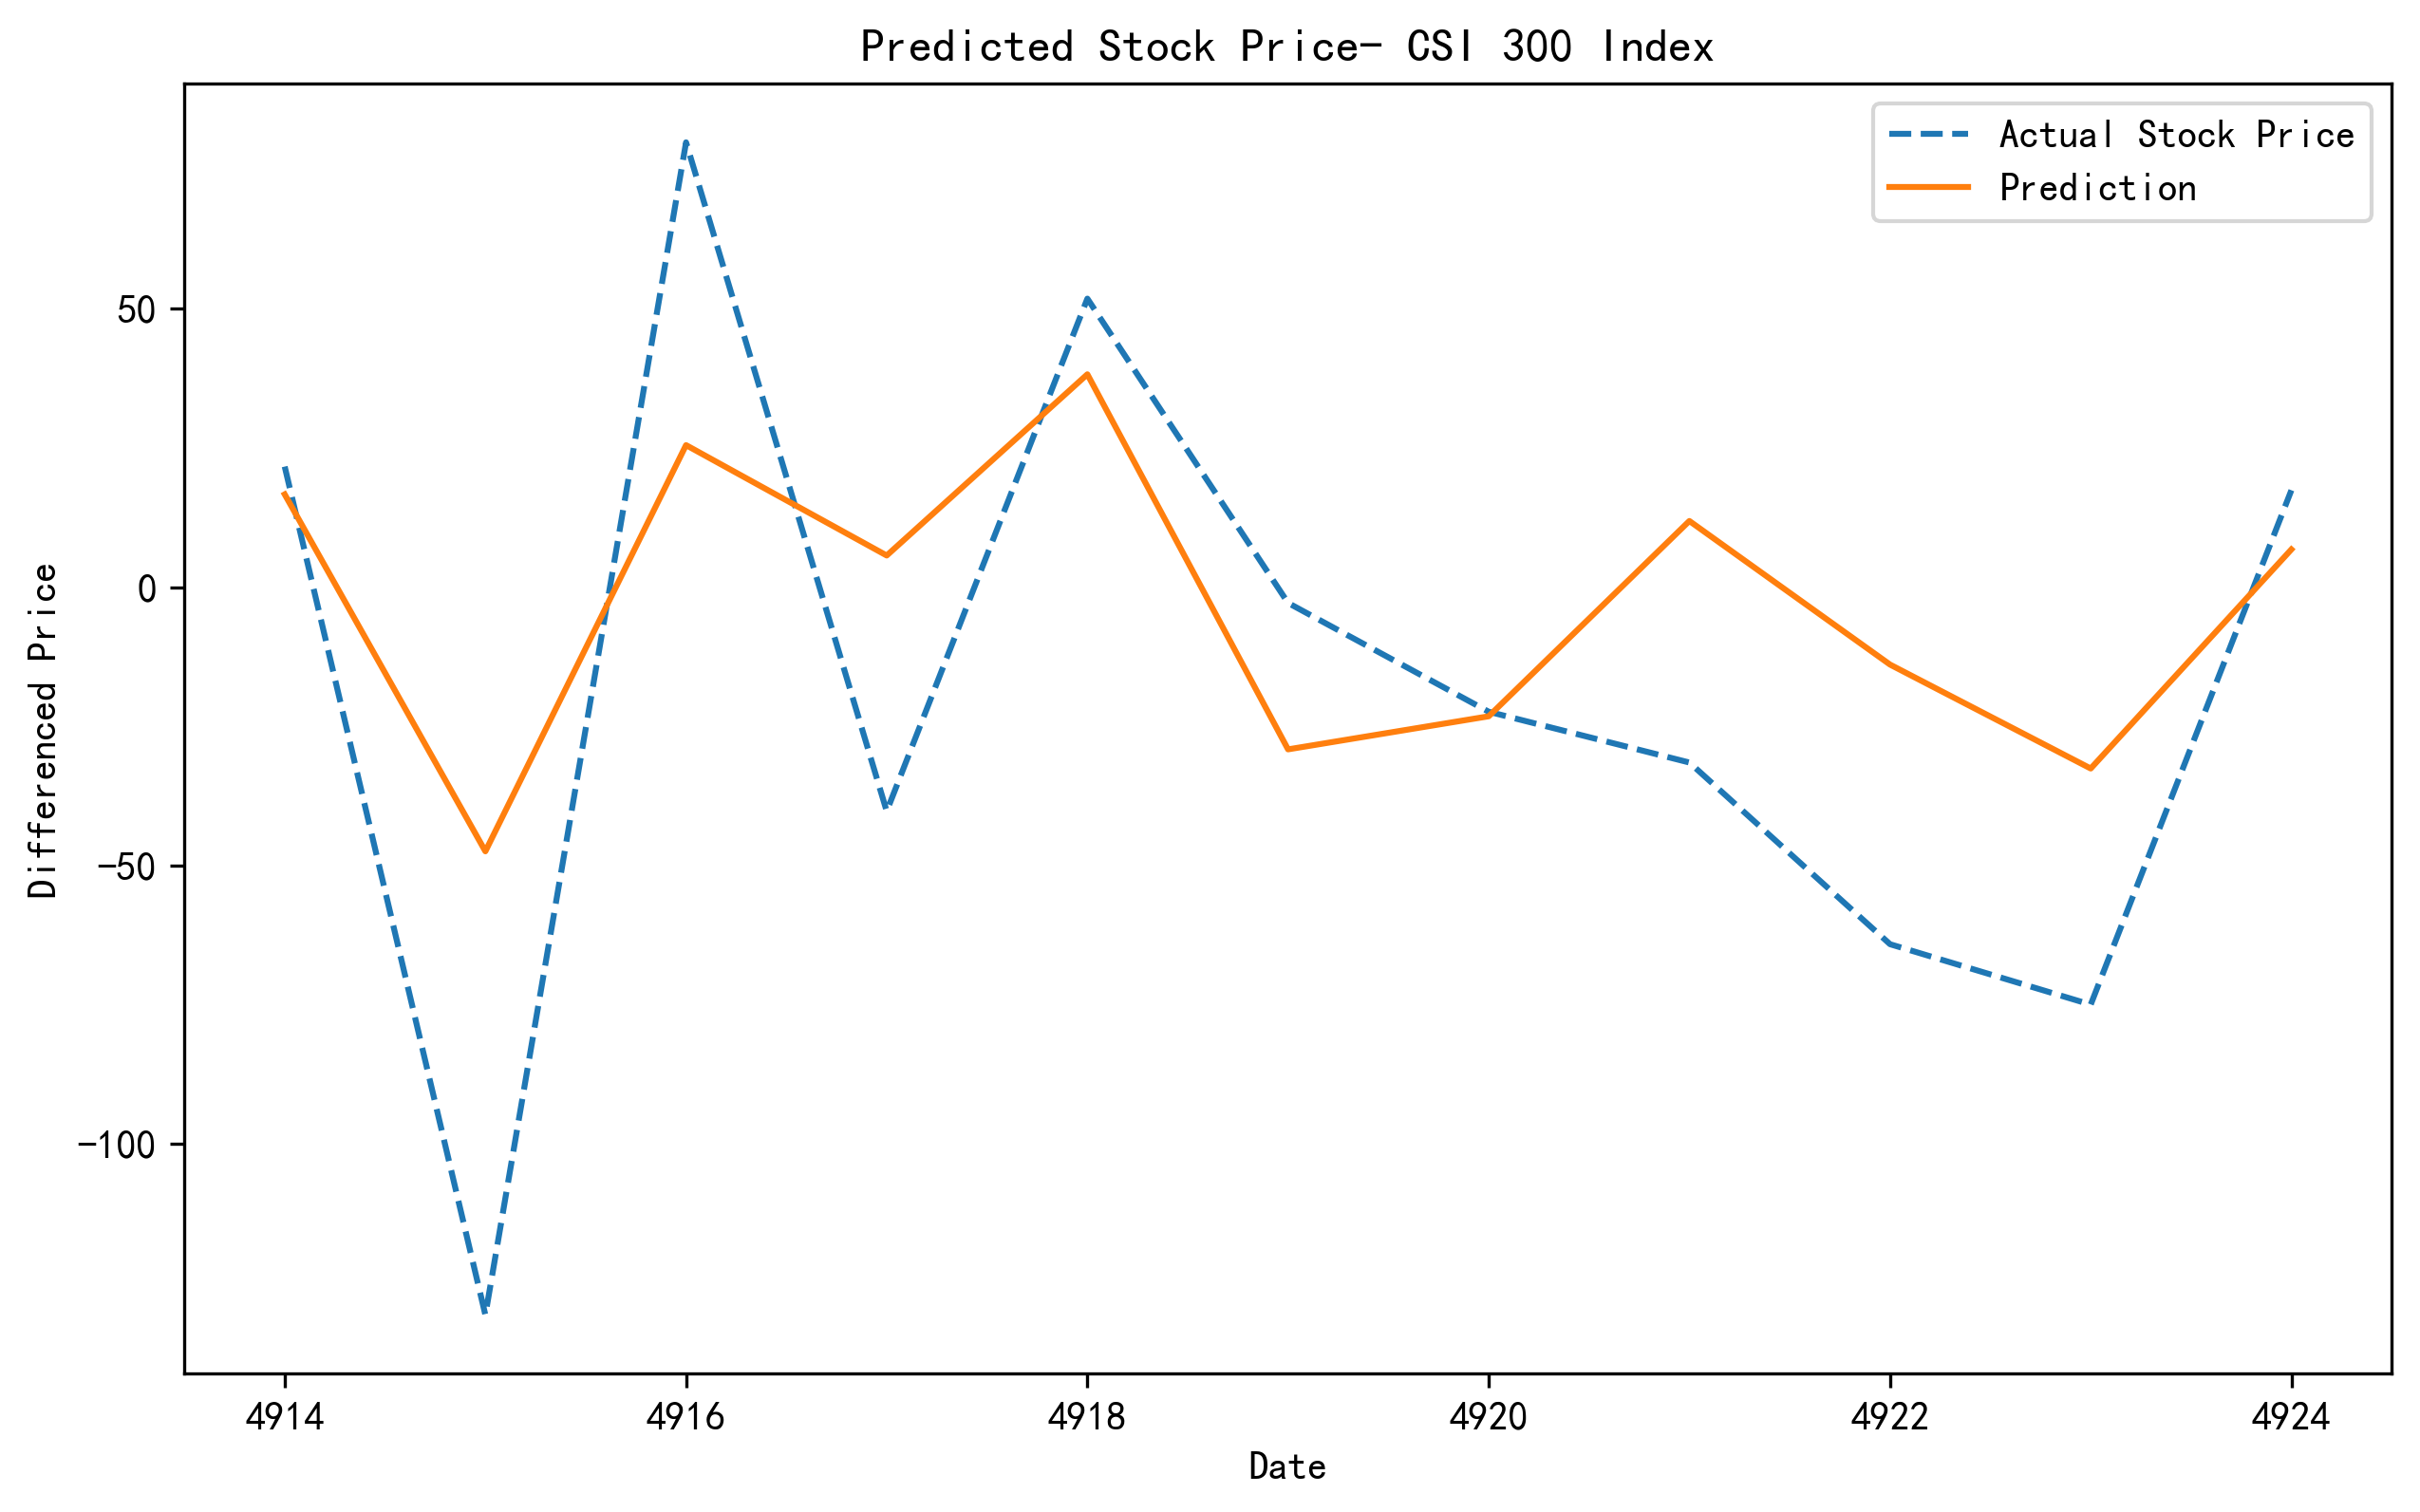

In [84]:
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(csi300Diff_test, label='Actual Stock Price', linestyle='--')
ax.plot(csi300Diff_test.index, np.array(tempList_csi300).flatten(),
           linestyle='solid', label="Prediction")
ax.set_title('Predicted Stock Price- CSI 300 Index')
ax.legend(loc='best')
ax.set(xlabel='Date', ylabel='Differenced Price')
plt.show()

下面我们将同样的数据、结合长短期记忆网络（LSTM，Long Short-Term Memory）模型做预测，并和CNN模型对比下预测的准确率。